# 6-1. 프로젝트: 고양이 수염 스티커 만들기

### Step 1. 스티커 구하기

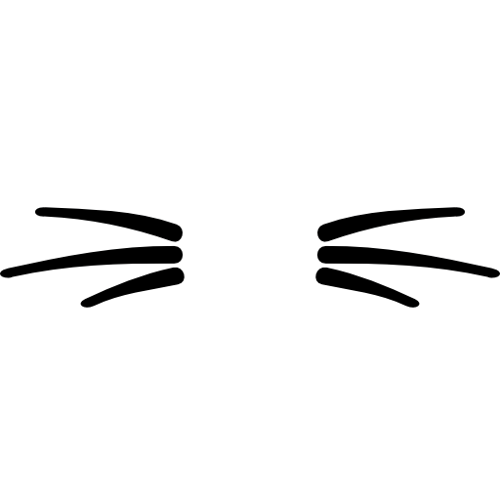

이 고양이 수염을 붙여 보겠습니다.

In [1]:
# 필요 패키지 import
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

cv2의 imshow 함수가 주피터에서 안되는 것 같아서 plt show 함수를 사용하기 위해 cv -> plt로 변환 하는 것을 함수로 생성

In [2]:
def imshow(img):
    img_bgr = img.copy()      # 출력용 이미지를 따로 보관합니다
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # bgr 이미지를 rgb 이미지로 변환
    plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
    plt.show() 

### Step 2. 얼굴 검출 & 랜드마크 검출 하기
 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾기

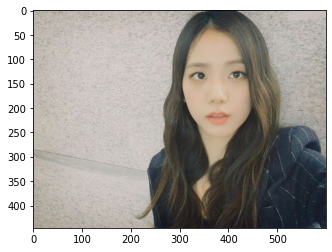

In [3]:
my_image_path = './JISU_1.png' # 본인 이미지가 있는 경로를 가지고 온다.
img = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr 이미지를 rgb 이미지로 변환
imshow(img)

rectangles[[(283, 77) (469, 263)]]


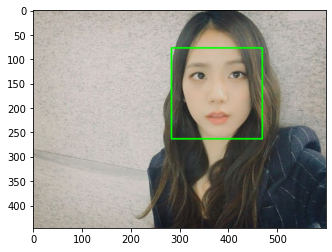

In [4]:
face_detector = dlib.get_frontal_face_detector() # face_detector 생성
dlib_rects = face_detector(img_rgb, 1) # face 
print(dlib_rects)

img_show = img.copy()
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
imshow(img_show)

In [5]:
list_landmarks = []
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # landmark detector 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

68


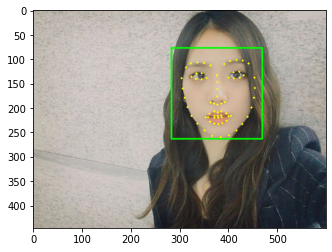

In [6]:
# 랜드마크가 잘 찍히나 확인하기 
# img_show = img.copy()
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
imshow(img_show)

### Step 3. 스티커 적용 위치 확인하기
고양이 수염이 적용 될 위치를 landmark를 사용해서 계산

In [7]:
# 스티커 w,h, x,y 계산
x = landmark[30][0]  # 코 위치
y = landmark[30][1]  # 코 위치
w = dlib_rect.width()
h = dlib_rect.height() / 4

In [8]:
# 코 중앙을 기준으로 한번 그려보자
img_sticker = cv2.imread('./cat_sk.jpg')  
img_sticker = cv2.resize(img_sticker, (int(w),int(h)))

refined_x = int(x - w // 2)                 #  377 - (187//2) = 437-93 = 344
refined_y = int(y - img_sticker.shape[0]/2) # - h)  # 89-187 = -98

print(refined_y, y, h)
print(refined_x, x, w, w // 2)

# print(refined_y, refined_y,img_sticker.shape[0], refined_y+img_sticker.shape[0])
# print(refined_x, refined_x,img_sticker.shape[1], refined_x+img_sticker.shape[1])
img_show = img.copy()
sticker_area = img_show[int(refined_y):int(refined_y+img_sticker.shape[0]), int(refined_x):int(refined_x+img_sticker.shape[1])]

153 176 46.75
284 377 187 93


### Step 4. 스티커 적용하기
```np.where``` 를 사용해서 스티커를 적용

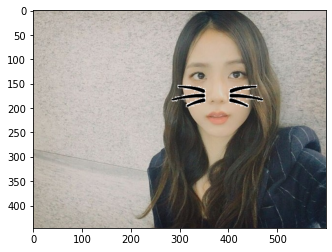

In [9]:
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
     np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

imshow(img_show)

opencv 의 ```cv2.addWeighted()```등을 이용하여 스티쿼 뒤로 원본 이미지가 보이도록 알파 값 조정

### Step 5. 문제점 찾아보기

다양한 각도에서 촬영하면서 스티커를 반복해서 적용

 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 
 
 ex) 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.
 
    - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    - 실행 속도가 중요할까요?
    - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?